# Demand Curve Analysis (Work Package 2.6)

**Objective:** Understand the relationship between price and quantity demanded to identify:
- Price sensitivity across different segments
- Optimal pricing points for revenue maximization
- Price elasticity by event type and buyer category

**Approach:**
- Create demand curves showing price vs. quantity sold
- Compare curves across event types (Classical, Special, Holiday)
- Compare curves across buyer types (Single Ticket vs Subscribers)
- Calculate price elasticity to measure sensitivity


In [2]:
!pip install scipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 16.4 MB/s  0:00:01 eta 0:00:01


In [3]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy import stats as scipy_stats
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Set style for plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✓ Libraries imported successfully")


✓ Libraries imported successfully


## Load Data


In [4]:
# Load master tickets dataset
print("Loading master_tickets.csv...")
master_tickets = pd.read_csv('master_tickets.csv')

print(f"✓ Loaded {len(master_tickets):,} ticket records")
print(f"✓ Columns: {len(master_tickets.columns)}")
print()

# Convert date columns
date_columns = ['event_date', 'add_datetime']
for col in date_columns:
    if col in master_tickets.columns:
        master_tickets[col] = pd.to_datetime(master_tickets[col], errors='coerce')

print(f"✓ Date range: {master_tickets['add_datetime'].min()} to {master_tickets['add_datetime'].max()}")
print()

# Filter to paid tickets only (exclude comps)
paid_tickets = master_tickets[master_tickets['comp'] != 'Y'].copy()
print(f"Paid tickets (excluding comps): {len(paid_tickets):,} records")
print()

# Show sample
print("Sample data:")
paid_tickets.head()


Loading master_tickets.csv...
✓ Loaded 73,534 ticket records
✓ Columns: 33

✓ Date range: 2022-03-02 00:00:00 to 2024-06-16 00:00:00

Paid tickets (excluding comps): 73,534 records

Sample data:


,fiscal_year,acct_id,is_college_pass,event_name,event_date,add_datetime,days_before_event,section_name,row_name,seat_num,last_seat,num_seats,price_code,price_code_type,price_section,purchase_price,paid_amount,comp,comp_name,source,ticket_type,age,gender,marital_status,education,zip,Weekend,Series,Name,Type,month,month_name,season_period
0,FY23,8362049,False,230922SE,2022-09-22,2022-07-15,69.00,BALCL,A,4,5,2,ICO,CYO Subscription,Front Balcony,34.00,68.00,N,Not Comp,online,Subscription,58.00,Male,Single,NaN,30041,CS1,1,Opening Weekend,Classical,7.00,July,Off-Season
1,FY23,8449640,False,230922SE,2022-09-22,2022-09-14,8.00,BALCL,B,1,2,2,IS1,Fixed Sophomore Subscription 6 Concert,Front Balcony,23.00,46.00,N,Not Comp,ASO Staff,Subscription,80.00,Male,Married,Graduate School,30316,CS1,1,Opening Weekend,Classical,9.00,September,Opening
2,FY23,4061365,False,230922SE,2022-09-22,2022-07-27,57.00,BALCL,B,4,5,2,ICO,CYO Subscription,Front Balcony,34.00,68.00,N,Not Comp,online,Subscription,58.00,Female,Single,College,30308,CS1,1,Opening Weekend,Classical,7.00,July,Off-Season
3,FY23,354115,False,230922SE,2022-09-22,2022-04-05,170.00,BALCL,C,1,2,2,IE4,Fixed Established Subscription 24 Concert,Front Balcony,30.00,60.00,N,Not Comp,ASO Staff,Subscription,72.00,Male,Married,College,30087,CS1,1,Opening Weekend,Classical,4.00,April,Peak
4,FY23,8908470,False,230922SE,2022-09-22,2022-09-20,2.00,BALCL,C,3,4,2,I*,Single Ticket,Front Balcony,30.00,60.00,N,Not Comp,online,Single Ticket,24.00,Male,Inferred Single,High School,30253,CS1,1,Opening Weekend,Classical,9.00,September,Opening


## Data Preparation for Demand Curves


In [5]:
# Demand Curve Analysis - Data Preparation
print("=" * 80)
print("DEMAND CURVE ANALYSIS - DATA PREPARATION")
print("=" * 80)
print()

# Filter for positive prices
demand_data = paid_tickets[paid_tickets['paid_amount'] > 0].copy()

print(f"Records for demand analysis: {len(demand_data):,}")
print(f"Price range: ${demand_data['paid_amount'].min():.2f} to ${demand_data['paid_amount'].max():.2f}")
print(f"Date range: {demand_data['add_datetime'].min()} to {demand_data['add_datetime'].max()}")
print()

# Check available columns
print("Available segmentation columns:")
if 'Type' in demand_data.columns:
    print(f"  Event types: {demand_data['Type'].value_counts().to_dict()}")
if 'ticket_type' in demand_data.columns:
    print(f"  Ticket types: {demand_data['ticket_type'].value_counts().to_dict()}")
print()

# Check for outliers that might distort curves
percentile_95 = demand_data['paid_amount'].quantile(0.95)
percentile_99 = demand_data['paid_amount'].quantile(0.99)
print(f"Price percentiles:")
print(f"  95th percentile: ${percentile_95:.2f}")
print(f"  99th percentile: ${percentile_99:.2f}")
print(f"  Tickets above 99th percentile: {(demand_data['paid_amount'] > percentile_99).sum():,}")
print()

# Create filtered dataset excluding extreme outliers for cleaner curves
demand_data_filtered = demand_data[demand_data['paid_amount'] <= percentile_99].copy()
print(f"Filtered dataset (≤99th percentile): {len(demand_data_filtered):,} records")
print(f"Price range: ${demand_data_filtered['paid_amount'].min():.2f} to ${demand_data_filtered['paid_amount'].max():.2f}")
print()


DEMAND CURVE ANALYSIS - DATA PREPARATION

Records for demand analysis: 67,974
Price range: $10.00 to $1615.00
Date range: 2022-03-02 00:00:00 to 2024-06-16 00:00:00

Available segmentation columns:
  Event types: {'Classical': 58560, 'Holiday': 6254, 'Special': 2579}
  Ticket types: {'Single Ticket': 34340, 'Subscription': 33199}

Price percentiles:
  95th percentile: $234.00
  99th percentile: $372.00
  Tickets above 99th percentile: 644

Filtered dataset (≤99th percentile): 67,330 records
Price range: $10.00 to $372.00



## A. Overall Demand Curve


In [6]:
# A. Overall Demand Curve
print("=" * 80)
print("A. OVERALL DEMAND CURVE")
print("=" * 80)
print()

# Aggregate quantity by price point
demand_overall = demand_data_filtered.groupby('paid_amount').agg({
    'num_seats': 'sum',
    'acct_id': 'count',
    'event_name': 'nunique'
}).reset_index()

demand_overall.columns = ['price', 'seats_sold', 'transactions', 'num_events']
demand_overall['total_revenue'] = demand_overall['price'] * demand_overall['seats_sold']

print(f"Unique price points: {len(demand_overall)}")
print(f"Price range: ${demand_overall['price'].min():.2f} to ${demand_overall['price'].max():.2f}")
print()

# Summary statistics
print("Demand curve summary:")
print(f"  Total seats: {demand_overall['seats_sold'].sum():,}")
print(f"  Total revenue: ${demand_overall['total_revenue'].sum():,.2f}")
print(f"  Mean seats per price point: {demand_overall['seats_sold'].mean():.1f}")
print(f"  Median seats per price point: {demand_overall['seats_sold'].median():.1f}")
print()

# Find price with highest quantity
max_qty_idx = demand_overall['seats_sold'].idxmax()
max_qty_price = demand_overall.loc[max_qty_idx, 'price']
max_qty_seats = demand_overall.loc[max_qty_idx, 'seats_sold']
print(f"Price with highest quantity: ${max_qty_price:.2f} ({max_qty_seats:,.0f} seats)")

# Find price with highest revenue
max_rev_idx = demand_overall['total_revenue'].idxmax()
max_rev_price = demand_overall.loc[max_rev_idx, 'price']
max_rev_amount = demand_overall.loc[max_rev_idx, 'total_revenue']
print(f"Price with highest revenue: ${max_rev_price:.2f} (${max_rev_amount:,.2f})")
print()

# Calculate simple price elasticity
demand_overall_sorted = demand_overall.sort_values('price')
price_changes = demand_overall_sorted['price'].pct_change()
qty_changes = demand_overall_sorted['seats_sold'].pct_change()

valid_elasticity = (price_changes != 0) & (price_changes.notna()) & (qty_changes.notna())
elasticity_values = (qty_changes[valid_elasticity] / price_changes[valid_elasticity])
elasticity_filtered = elasticity_values[(elasticity_values > -10) & (elasticity_values < 10)]
avg_elasticity = elasticity_filtered.mean()

print(f"Average price elasticity: {avg_elasticity:.2f}")
if avg_elasticity < -1:
    print("  → ELASTIC: Demand is highly sensitive to price changes")
elif avg_elasticity < 0:
    print("  → INELASTIC: Demand is relatively insensitive to price changes")
else:
    print("  → Note: Positive elasticity may indicate pricing complexity")
print()


A. OVERALL DEMAND CURVE

Unique price points: 565
Price range: $10.00 to $372.00

Demand curve summary:
  Total seats: 126,698
  Total revenue: $15,123,694.10
  Mean seats per price point: 224.2
  Median seats per price point: 41.0

Price with highest quantity: $90.00 (4,335 seats)
Price with highest revenue: $212.00 ($426,968.00)

Average price elasticity: -1.53
  → ELASTIC: Demand is highly sensitive to price changes



In [7]:
# B. Demand Curves by Event Type
print("=" * 80)
print("B. DEMAND CURVES BY EVENT TYPE")
print("=" * 80)
print()

if 'Type' in demand_data_filtered.columns:
    event_types = demand_data_filtered['Type'].dropna().unique()
    print(f"Event types found: {list(event_types)}")
    print()
    
    demand_by_type = {}
    
    for event_type in sorted(event_types):
        type_data = demand_data_filtered[demand_data_filtered['Type'] == event_type]
        
        demand_type = type_data.groupby('paid_amount').agg({
            'num_seats': 'sum',
            'acct_id': 'count'
        }).reset_index()
        demand_type.columns = ['price', 'seats_sold', 'transactions']
        demand_type['total_revenue'] = demand_type['price'] * demand_type['seats_sold']
        
        demand_by_type[event_type] = demand_type
        
        print(f"{event_type}:")
        print(f"  Total tickets: {type_data.shape[0]:,}")
        print(f"  Total seats: {demand_type['seats_sold'].sum():,}")
        print(f"  Total revenue: ${demand_type['total_revenue'].sum():,.2f}")
        print(f"  Price range: ${demand_type['price'].min():.2f} - ${demand_type['price'].max():.2f}")
        print(f"  Avg price: ${type_data['paid_amount'].mean():.2f}")
        print(f"  Median price: ${type_data['paid_amount'].median():.2f}")
        
        # Calculate elasticity for this type
        demand_type_sorted = demand_type.sort_values('price')
        price_changes = demand_type_sorted['price'].pct_change()
        qty_changes = demand_type_sorted['seats_sold'].pct_change()
        
        valid = (price_changes != 0) & (price_changes.notna()) & (qty_changes.notna())
        if valid.sum() > 0:
            elasticity = (qty_changes[valid] / price_changes[valid])
            elasticity_filtered = elasticity[(elasticity > -10) & (elasticity < 10)]
            if len(elasticity_filtered) > 0:
                avg_elast = elasticity_filtered.mean()
                print(f"  Price elasticity: {avg_elast:.2f}", end="")
                if avg_elast < -1:
                    print(" (ELASTIC)")
                elif avg_elast < 0:
                    print(" (INELASTIC)")
                else:
                    print()
        print()
    
    print("Price comparison across event types:")
    price_comparison = demand_data_filtered.groupby('Type')['paid_amount'].agg(['mean', 'median', 'std']).round(2)
    print(price_comparison)
    print()
    
else:
    print("⚠ 'Type' column not found - cannot segment by event type")
    demand_by_type = {}
    print()


B. DEMAND CURVES BY EVENT TYPE

Event types found: ['Classical', 'Holiday', 'Special']

Classical:
  Total tickets: 58,179
  Total seats: 105,548
  Total revenue: $11,715,943.64
  Price range: $10.00 - $372.00
  Avg price: $96.96
  Median price: $83.00
  Price elasticity: -0.15 (INELASTIC)

Holiday:
  Total tickets: 6,078
  Total seats: 14,915
  Total revenue: $2,401,996.06
  Price range: $14.00 - $372.00
  Avg price: $134.13
  Median price: $118.00
  Price elasticity: -0.97 (INELASTIC)

Special:
  Total tickets: 2,507
  Total seats: 4,752
  Total revenue: $746,462.00
  Price range: $20.00 - $356.00
  Avg price: $140.92
  Median price: $130.00
  Price elasticity: 0.82

Price comparison across event types:
            mean  median   std
Type                          
Classical  96.96   83.00 61.80
Holiday   134.13  118.00 74.36
Special   140.92  130.00 77.94



In [8]:
# C. Demand Curves by Buyer Type
print("=" * 80)
print("C. DEMAND CURVES BY BUYER TYPE")
print("=" * 80)
print()

# Use ticket_type for segmentation
if 'ticket_type' in demand_data_filtered.columns:
    buyer_col = 'ticket_type'
    print("Using 'ticket_type' for segmentation")
else:
    buyer_col = None
    print("⚠ No buyer type column found")

if buyer_col:
    buyer_types = demand_data_filtered[buyer_col].dropna().unique()
    print(f"Buyer types found: {list(buyer_types)}")
    print()
    
    demand_by_buyer = {}
    
    for buyer_type in sorted(buyer_types):
        buyer_data = demand_data_filtered[demand_data_filtered[buyer_col] == buyer_type]
        
        demand_buyer = buyer_data.groupby('paid_amount').agg({
            'num_seats': 'sum',
            'acct_id': 'count'
        }).reset_index()
        demand_buyer.columns = ['price', 'seats_sold', 'transactions']
        demand_buyer['total_revenue'] = demand_buyer['price'] * demand_buyer['seats_sold']
        
        demand_by_buyer[buyer_type] = demand_buyer
        
        print(f"{buyer_type}:")
        print(f"  Total tickets: {buyer_data.shape[0]:,}")
        print(f"  Total seats: {demand_buyer['seats_sold'].sum():,}")
        print(f"  Total revenue: ${demand_buyer['total_revenue'].sum():,.2f}")
        print(f"  Price range: ${demand_buyer['price'].min():.2f} - ${demand_buyer['price'].max():.2f}")
        print(f"  Avg price: ${buyer_data['paid_amount'].mean():.2f}")
        print(f"  Median price: ${buyer_data['paid_amount'].median():.2f}")
        
        # Calculate elasticity
        demand_buyer_sorted = demand_buyer.sort_values('price')
        price_changes = demand_buyer_sorted['price'].pct_change()
        qty_changes = demand_buyer_sorted['seats_sold'].pct_change()
        
        valid = (price_changes != 0) & (price_changes.notna()) & (qty_changes.notna())
        if valid.sum() > 0:
            elasticity = (qty_changes[valid] / price_changes[valid])
            elasticity_filtered = elasticity[(elasticity > -10) & (elasticity < 10)]
            if len(elasticity_filtered) > 0:
                avg_elast = elasticity_filtered.mean()
                print(f"  Price elasticity: {avg_elast:.2f}", end="")
                if avg_elast < -1:
                    print(" (ELASTIC - sensitive to price)")
                elif avg_elast < 0:
                    print(" (INELASTIC - less sensitive)")
                else:
                    print()
        print()
    
    print("Price comparison across buyer types:")
    buyer_price_comparison = demand_data_filtered.groupby(buyer_col)['paid_amount'].agg(['mean', 'median', 'std', 'count']).round(2)
    print(buyer_price_comparison)
    print()
    
    # Statistical test
    print("Statistical comparison:")
    buyer_types_list = list(buyer_types)
    if len(buyer_types_list) >= 2:
        group1 = demand_data_filtered[demand_data_filtered[buyer_col] == buyer_types_list[0]]['paid_amount']
        group2 = demand_data_filtered[demand_data_filtered[buyer_col] == buyer_types_list[1]]['paid_amount']
        
        t_stat, p_value = scipy_stats.ttest_ind(group1, group2)
        print(f"  T-test comparing {buyer_types_list[0]} vs {buyer_types_list[1]}:")
        print(f"    Mean difference: ${group1.mean() - group2.mean():.2f}")
        print(f"    p-value: {p_value:.4f}", end="")
        if p_value < 0.05:
            print(" (SIGNIFICANT difference)")
        else:
            print(" (not significant)")
    print()
    
else:
    demand_by_buyer = {}
    print()


C. DEMAND CURVES BY BUYER TYPE

Using 'ticket_type' for segmentation
Buyer types found: ['Subscription', 'Single Ticket']

Single Ticket:
  Total tickets: 33,758
  Total seats: 67,650
  Total revenue: $9,265,315.51
  Price range: $10.00 - $372.00
  Avg price: $115.48
  Median price: $102.00
  Price elasticity: -1.98 (ELASTIC - sensitive to price)

Subscription:
  Total tickets: 33,137
  Total seats: 58,608
  Total revenue: $5,851,624.59
  Price range: $10.50 - $372.00
  Avg price: $90.12
  Median price: $76.00
  Price elasticity: -0.68 (INELASTIC - less sensitive)

Price comparison across buyer types:
                mean  median   std  count
ticket_type                              
Single Ticket 115.48  102.00 69.26  33758
Subscription   90.12   76.00 58.08  33137

Statistical comparison:
  T-test comparing Subscription vs Single Ticket:
    Mean difference: $-25.36
    p-value: 0.0000 (SIGNIFICANT difference)



Creating Visualization 1: Overall Demand Curve

✓ Saved: WP2_6_Overall_Demand_Curve.png


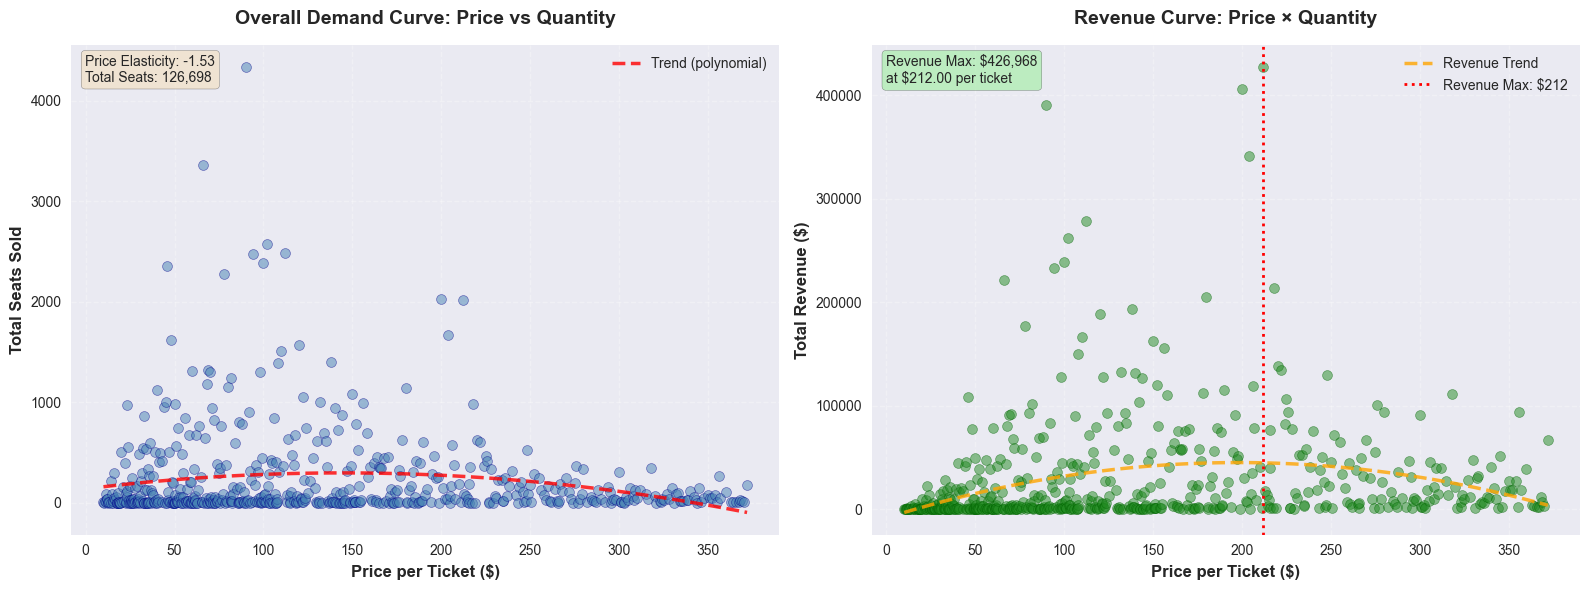

In [9]:
# Visualization 1: Overall Demand Curve
print("Creating Visualization 1: Overall Demand Curve")
print()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Left panel: Price vs Quantity
ax1.scatter(demand_overall['price'], demand_overall['seats_sold'], 
           alpha=0.5, s=50, color='steelblue', edgecolors='darkblue', linewidth=0.5)

# Add polynomial trendline
if len(demand_overall) > 3:
    z = np.polyfit(demand_overall['price'], demand_overall['seats_sold'], 2)
    p = np.poly1d(z)
    x_line = np.linspace(demand_overall['price'].min(), demand_overall['price'].max(), 100)
    ax1.plot(x_line, p(x_line), "r--", linewidth=2.5, label='Trend (polynomial)', alpha=0.8)

ax1.set_xlabel('Price per Ticket ($)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Total Seats Sold', fontsize=12, fontweight='bold')
ax1.set_title('Overall Demand Curve: Price vs Quantity', fontsize=14, fontweight='bold', pad=15)
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.legend(fontsize=10)

ax1.text(0.02, 0.98, f"Price Elasticity: {avg_elasticity:.2f}\nTotal Seats: {demand_overall['seats_sold'].sum():,}", 
        transform=ax1.transAxes, fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Right panel: Revenue Curve
ax2.scatter(demand_overall['price'], demand_overall['total_revenue'], 
           alpha=0.5, s=50, color='forestgreen', edgecolors='darkgreen', linewidth=0.5)

if len(demand_overall) > 3:
    z_rev = np.polyfit(demand_overall['price'], demand_overall['total_revenue'], 2)
    p_rev = np.poly1d(z_rev)
    ax2.plot(x_line, p_rev(x_line), "orange", linewidth=2.5, label='Revenue Trend', alpha=0.8, linestyle='--')

ax2.axvline(x=max_rev_price, color='red', linestyle=':', linewidth=2, label=f'Revenue Max: ${max_rev_price:.0f}')

ax2.set_xlabel('Price per Ticket ($)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Total Revenue ($)', fontsize=12, fontweight='bold')
ax2.set_title('Revenue Curve: Price × Quantity', fontsize=14, fontweight='bold', pad=15)
ax2.grid(True, alpha=0.3, linestyle='--')
ax2.legend(fontsize=10)

ax2.text(0.02, 0.98, f"Revenue Max: ${max_rev_amount:,.0f}\nat ${max_rev_price:.2f} per ticket", 
        transform=ax2.transAxes, fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))

plt.tight_layout()
plt.savefig('WP2_6_Overall_Demand_Curve.png', dpi=300, bbox_inches='tight')
print("✓ Saved: WP2_6_Overall_Demand_Curve.png")
plt.show()
print()


Creating Visualization 2: Demand Curves by Event Type

✓ Saved: WP2_6_Demand_by_Event_Type.png


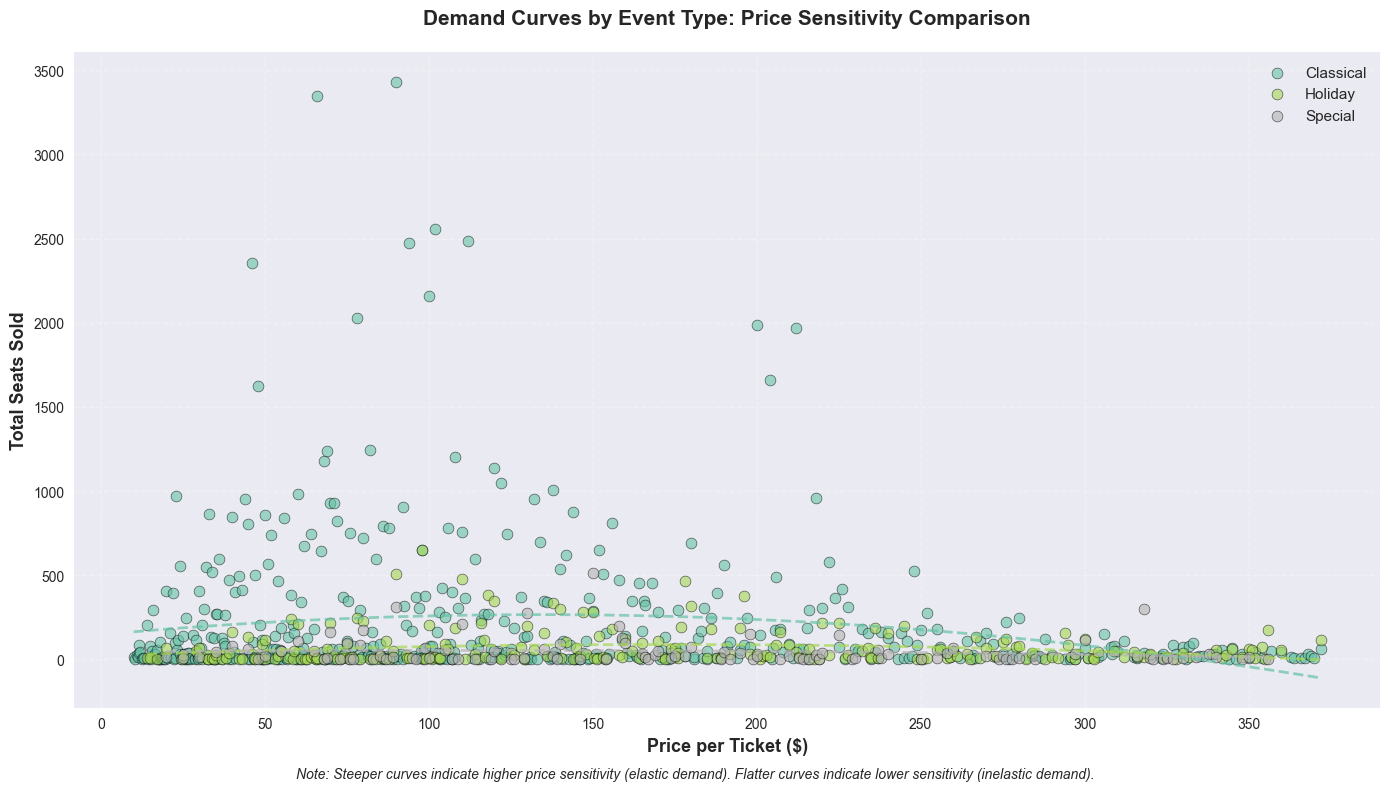

In [10]:
# Visualization 2: Demand Curves by Event Type
if demand_by_type:
    print("Creating Visualization 2: Demand Curves by Event Type")
    print()
    
    fig, ax = plt.subplots(figsize=(14, 8))
    
    colors = plt.cm.Set2(np.linspace(0, 1, len(demand_by_type)))
    
    for idx, (event_type, demand_df) in enumerate(sorted(demand_by_type.items())):
        color = colors[idx]
        
        ax.scatter(demand_df['price'], demand_df['seats_sold'], 
                  alpha=0.6, s=60, color=color, label=event_type, edgecolors='black', linewidth=0.5)
        
        if len(demand_df) > 3:
            try:
                z = np.polyfit(demand_df['price'], demand_df['seats_sold'], 2)
                p = np.poly1d(z)
                x_line = np.linspace(demand_df['price'].min(), demand_df['price'].max(), 50)
                ax.plot(x_line, p(x_line), color=color, linewidth=2, alpha=0.7, linestyle='--')
            except:
                pass
    
    ax.set_xlabel('Price per Ticket ($)', fontsize=13, fontweight='bold')
    ax.set_ylabel('Total Seats Sold', fontsize=13, fontweight='bold')
    ax.set_title('Demand Curves by Event Type: Price Sensitivity Comparison', 
                fontsize=15, fontweight='bold', pad=20)
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.legend(fontsize=11, loc='best', framealpha=0.9)
    
    fig.text(0.5, 0.02, 
            'Note: Steeper curves indicate higher price sensitivity (elastic demand). Flatter curves indicate lower sensitivity (inelastic demand).',
            ha='center', fontsize=10, style='italic', wrap=True)
    
    plt.tight_layout(rect=[0, 0.03, 1, 1])
    plt.savefig('WP2_6_Demand_by_Event_Type.png', dpi=300, bbox_inches='tight')
    print("✓ Saved: WP2_6_Demand_by_Event_Type.png")
    plt.show()
    print()
else:
    print("⚠ Skipping event type visualization - no data available")
    print()


Creating Visualization 3: Demand Curves by Buyer Type

✓ Saved: WP2_6_Demand_by_Buyer_Type.png


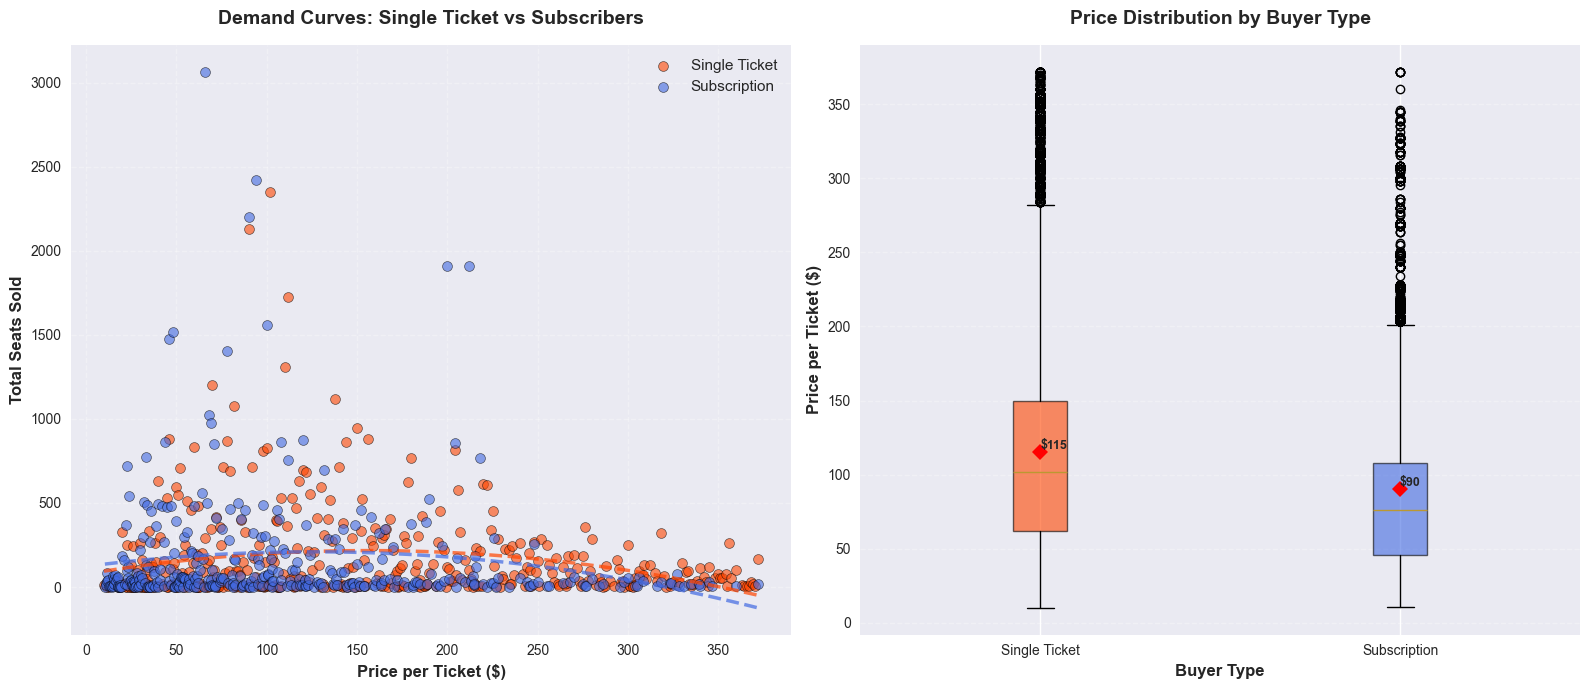

In [11]:
# Visualization 3: Demand Curves by Buyer Type
if demand_by_buyer:
    print("Creating Visualization 3: Demand Curves by Buyer Type")
    print()
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
    
    colors_buyer = {'Single Ticket': 'orangered', 'Subscription': 'royalblue'}
    default_colors = plt.cm.Set1(np.linspace(0, 1, len(demand_by_buyer)))
    
    # Left panel: Demand curves overlaid
    for idx, (buyer_type, demand_df) in enumerate(sorted(demand_by_buyer.items())):
        color = colors_buyer.get(buyer_type, default_colors[idx])
        
        ax1.scatter(demand_df['price'], demand_df['seats_sold'], 
                   alpha=0.6, s=50, color=color, label=buyer_type, edgecolors='black', linewidth=0.5)
        
        if len(demand_df) > 3:
            try:
                z = np.polyfit(demand_df['price'], demand_df['seats_sold'], 2)
                p = np.poly1d(z)
                x_line = np.linspace(demand_df['price'].min(), demand_df['price'].max(), 50)
                ax1.plot(x_line, p(x_line), color=color, linewidth=2.5, alpha=0.7, linestyle='--')
            except:
                pass
    
    ax1.set_xlabel('Price per Ticket ($)', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Total Seats Sold', fontsize=12, fontweight='bold')
    ax1.set_title('Demand Curves: Single Ticket vs Subscribers', fontsize=14, fontweight='bold', pad=15)
    ax1.grid(True, alpha=0.3, linestyle='--')
    ax1.legend(fontsize=11, loc='best', framealpha=0.9)
    
    # Right panel: Price distributions
    buyer_price_data = []
    buyer_labels = []
    for buyer_type in sorted(demand_by_buyer.keys()):
        if buyer_col and buyer_type in demand_data_filtered[buyer_col].values:
            prices = demand_data_filtered[demand_data_filtered[buyer_col] == buyer_type]['paid_amount']
            buyer_price_data.append(prices)
            buyer_labels.append(buyer_type)
    
    if buyer_price_data:
        bp = ax2.boxplot(buyer_price_data, labels=buyer_labels, patch_artist=True, showmeans=True,
                        meanprops=dict(marker='D', markerfacecolor='red', markersize=8))
        
        for patch, buyer_type in zip(bp['boxes'], buyer_labels):
            color = colors_buyer.get(buyer_type, 'lightgray')
            patch.set_facecolor(color)
            patch.set_alpha(0.6)
        
        ax2.set_ylabel('Price per Ticket ($)', fontsize=12, fontweight='bold')
        ax2.set_xlabel('Buyer Type', fontsize=12, fontweight='bold')
        ax2.set_title('Price Distribution by Buyer Type', fontsize=14, fontweight='bold', pad=15)
        ax2.grid(True, alpha=0.3, linestyle='--', axis='y')
        
        for idx, (buyer_type, prices) in enumerate(zip(buyer_labels, buyer_price_data)):
            mean_price = prices.mean()
            ax2.text(idx + 1, mean_price, f'${mean_price:.0f}', 
                    ha='left', va='bottom', fontsize=9, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('WP2_6_Demand_by_Buyer_Type.png', dpi=300, bbox_inches='tight')
    print("✓ Saved: WP2_6_Demand_by_Buyer_Type.png")
    plt.show()
    print()
else:
    print("⚠ Skipping buyer type visualization - no data available")
    print()


## Summary and Key Findings


In [12]:
# Summary of Demand Curve Analysis
print("=" * 80)
print("DEMAND CURVE ANALYSIS - KEY FINDINGS")
print("=" * 80)
print()

print("1. OVERALL DEMAND CHARACTERISTICS:")
print(f"   • Price range analyzed: ${demand_data_filtered['paid_amount'].min():.2f} - ${demand_data_filtered['paid_amount'].max():.2f}")
print(f"   • Total seats analyzed: {demand_overall['seats_sold'].sum():,}")
print(f"   • Average price elasticity: {avg_elasticity:.2f}", end="")
if avg_elasticity < -1:
    print(" (ELASTIC - demand is sensitive to price)")
elif avg_elasticity < 0:
    print(" (INELASTIC - demand is less sensitive to price)")
else:
    print()
print(f"   • Price with highest quantity: ${max_qty_price:.2f} ({max_qty_seats:,.0f} seats)")
print(f"   • Price with highest revenue: ${max_rev_price:.2f} (${max_rev_amount:,.2f})")
print()

if demand_by_type:
    print("2. EVENT TYPE COMPARISON:")
    for event_type in sorted(demand_by_type.keys()):
        type_data = demand_data_filtered[demand_data_filtered['Type'] == event_type]
        avg_price = type_data['paid_amount'].mean()
        total_revenue = demand_by_type[event_type]['total_revenue'].sum()
        print(f"   • {event_type}:")
        print(f"     - Average price: ${avg_price:.2f}")
        print(f"     - Total revenue: ${total_revenue:,.2f}")
        print(f"     - Total seats: {demand_by_type[event_type]['seats_sold'].sum():,}")
    print()

if demand_by_buyer:
    print("3. BUYER TYPE COMPARISON:")
    for buyer_type in sorted(demand_by_buyer.keys()):
        buyer_data = demand_data_filtered[demand_data_filtered[buyer_col] == buyer_type]
        avg_price = buyer_data['paid_amount'].mean()
        median_price = buyer_data['paid_amount'].median()
        total_revenue = demand_by_buyer[buyer_type]['total_revenue'].sum()
        pct_of_total = (len(buyer_data) / len(demand_data_filtered)) * 100
        print(f"   • {buyer_type}:")
        print(f"     - Average price: ${avg_price:.2f}")
        print(f"     - Median price: ${median_price:.2f}")
        print(f"     - Total revenue: ${total_revenue:,.2f}")
        print(f"     - % of tickets: {pct_of_total:.1f}%")
    print()

print("4. STRATEGIC INSIGHTS:")
print("   • Revenue maximization:")
if max_rev_price != max_qty_price:
    print(f"     - Current revenue max at ${max_rev_price:.2f} (not at highest volume price)")
    print(f"     - Consider testing prices around ${max_rev_price:.2f} for optimal revenue")
else:
    print(f"     - Revenue and volume maximized at same price point (${max_rev_price:.2f})")

if demand_by_buyer and 'Single Ticket' in demand_by_buyer and 'Subscription' in demand_by_buyer:
    single_avg = demand_data_filtered[demand_data_filtered[buyer_col] == 'Single Ticket']['paid_amount'].mean()
    sub_avg = demand_data_filtered[demand_data_filtered[buyer_col] == 'Subscription']['paid_amount'].mean()
    price_diff = single_avg - sub_avg
    print(f"   • Pricing strategy:")
    print(f"     - Single ticket buyers pay ${price_diff:.2f} more on average")
    print(f"     - Subscriber discount is effectively {(price_diff/single_avg)*100:.1f}%")

print()
print("=" * 80)
print("ANALYSIS COMPLETE")
print("=" * 80)
print()


DEMAND CURVE ANALYSIS - KEY FINDINGS

1. OVERALL DEMAND CHARACTERISTICS:
   • Price range analyzed: $10.00 - $372.00
   • Total seats analyzed: 126,698
   • Average price elasticity: -1.53 (ELASTIC - demand is sensitive to price)
   • Price with highest quantity: $90.00 (4,335 seats)
   • Price with highest revenue: $212.00 ($426,968.00)

2. EVENT TYPE COMPARISON:
   • Classical:
     - Average price: $96.96
     - Total revenue: $11,715,943.64
     - Total seats: 105,548
   • Holiday:
     - Average price: $134.13
     - Total revenue: $2,401,996.06
     - Total seats: 14,915
   • Special:
     - Average price: $140.92
     - Total revenue: $746,462.00
     - Total seats: 4,752

3. BUYER TYPE COMPARISON:
   • Single Ticket:
     - Average price: $115.48
     - Median price: $102.00
     - Total revenue: $9,265,315.51
     - % of tickets: 50.1%
   • Subscription:
     - Average price: $90.12
     - Median price: $76.00
     - Total revenue: $5,851,624.59
     - % of tickets: 49.2%

4. 

## Export Results


In [13]:
# Export Demand Curve Analysis Results
print("Exporting demand curve analysis results...")
print()

# Export overall demand curve
demand_overall.to_csv('WP2_6_Overall_Demand_Curve.csv', index=False)
print("✓ Exported: WP2_6_Overall_Demand_Curve.csv")

# Export demand by event type
if demand_by_type:
    for event_type, demand_df in demand_by_type.items():
        filename = f"WP2_6_Demand_{event_type.replace(' ', '_').replace('/', '_')}.csv"
        demand_df.to_csv(filename, index=False)
        print(f"✓ Exported: {filename}")

# Export demand by buyer type
if demand_by_buyer:
    for buyer_type, demand_df in demand_by_buyer.items():
        filename = f"WP2_6_Demand_{buyer_type.replace(' ', '_')}.csv"
        demand_df.to_csv(filename, index=False)
        print(f"✓ Exported: {filename}")

# Export summary statistics
summary_data = {
    'Metric': [
        'Price Range (Min)',
        'Price Range (Max)',
        'Total Seats Analyzed',
        'Average Price Elasticity',
        'Price with Highest Quantity',
        'Seats at Highest Quantity',
        'Price with Highest Revenue',
        'Revenue at Optimal Price'
    ],
    'Value': [
        f"${demand_data_filtered['paid_amount'].min():.2f}",
        f"${demand_data_filtered['paid_amount'].max():.2f}",
        f"{demand_overall['seats_sold'].sum():,}",
        f"{avg_elasticity:.2f}",
        f"${max_qty_price:.2f}",
        f"{max_qty_seats:,.0f}",
        f"${max_rev_price:.2f}",
        f"${max_rev_amount:,.2f}"
    ]
}

summary_df = pd.DataFrame(summary_data)
summary_df.to_csv('WP2_6_Demand_Summary.csv', index=False)
print("✓ Exported: WP2_6_Demand_Summary.csv")

print()
print("All demand curve analysis results exported successfully!")
print()
print("📊 Generated files:")
print("   - 3 PNG visualizations")
print("   - Multiple CSV data files")
print("   - Summary statistics file")


Exporting demand curve analysis results...

✓ Exported: WP2_6_Overall_Demand_Curve.csv
✓ Exported: WP2_6_Demand_Classical.csv
✓ Exported: WP2_6_Demand_Holiday.csv
✓ Exported: WP2_6_Demand_Special.csv
✓ Exported: WP2_6_Demand_Single_Ticket.csv
✓ Exported: WP2_6_Demand_Subscription.csv
✓ Exported: WP2_6_Demand_Summary.csv

All demand curve analysis results exported successfully!

📊 Generated files:
   - 3 PNG visualizations
   - Multiple CSV data files
   - Summary statistics file
